<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Learn_to_ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial - Learn to ranking

## Ideia Básica


####Vejamos o exemplo de itens de classificação para o feed de notícias de um usuário. Se tudo o que importássemos fossem os cliques, poderíamos simplesmente treinar um modelo para prever se um usuário clicará em cada item e classificá-los de acordo com a probabilidade de clique. No entanto, podemos nos preocupar com mais do que apenas cliques; por exemplo, se o usuário clicar em um artigo, mas não terminar de lê-lo, pode não ser tão interessante para ele e não vamos recomendar artigos semelhantes no futuro.

####É aqui que entra em ação o *LTR*: Em vez de usar alguma medida proxy (por exemplo, a probabilidade de um usuário clicar em um item), treinamos diretamente o modelo para classificar os itens.

####Especificamente, formulamos o problema da seguinte forma: temos um modelo que pega dois itens como entrada e prediz qual deles será classificado em relação ao outro. Uma maneira simples de fazer isso é treinar um modelo para atribuir uma "pontuação" a cada item, de modo que os itens de classificação mais alta tenham pontuações mais altas e os itens de classificação mais baixa tenham pontuações mais baixas. Esse modelo pode ser qualquer coisa, desde uma rede neural até um XGBoost. A única propriedade que gostaríamos que o modelo tivesse é que ele seja diferenciável para que possamos usar o método do gradiente para otimizá-lo.

####Observe que, com esta abordagem, você não precisa de uma ordem completa dos itens: na verdade, você pode ter classificações inconsistentes (por exemplo, o Item A possui maior classificação do que o Item B, o Item B possui maior classificação do que o Item C e o Item C possui maior classificação do que o Item A), o *LTR* ainda pode ter itens que não podem ser comparados uns com os outros!

####A primeira etapa para modelarmos o *LTR* é definir uma função de perda. Pelo  princípio de máxima verossimilhança, o modelo aprende uma distribuição de probabilidade sobre os resultados possíveis (a classificação) e maximizamos a probabilidade dos dados observados pelo modelo na etapa de treinamento.

####Como estamos fazendo com que o modelo preveja qual item tem melhor classificação, a maneira natural de aplicar a probabilidade máxima é modelar a probabilidade de um item ser classificado em relação ao outro usando as pontuações. Usamos a probabilidade de o modelo classificar cada par de itens corretamente com essa ideia de função de perda. Denotamos a pontuação de um item (indexado por $_i$) como $s_i$.

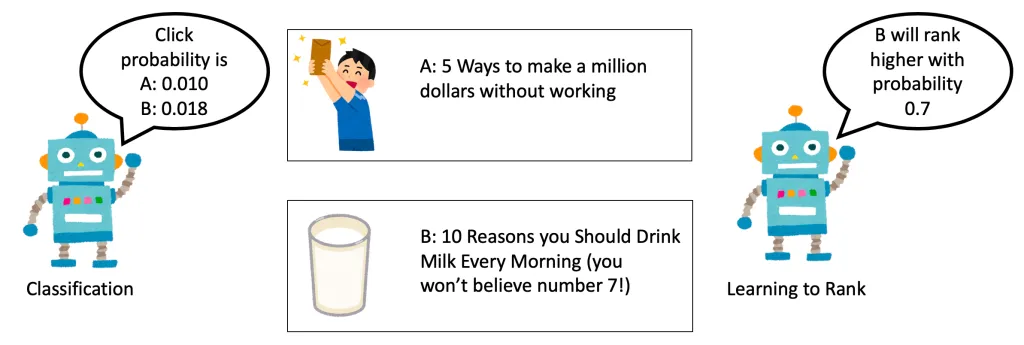

####Como devemos traduzir pontuações em probabilidade? Vamos considerar quais propriedades queremos dessa função de probabilidade:

> #### Queremos garantir que exista uma diferença entre as pontuações para que se traduza em probabilidades maiores.

> #### Quando as pontuações são iguais, queremos que a probabilidade seja $0.5$.

> #### A função de probabilidade deve ser simétrica. Em outras palavras, trocar $s_i$ e $s_j$ deve trocar as probabilidades.

#### Com essas considerações, a função sigmóide sobre a diferença nas pontuações é uma escolha natural.

####  $P(rank_i > rank_j)=\dfrac{1}{1+e^{-\alpha(s_i-s_j)}}$, onde $\alpha$ determina a "*inclinação*" da sigmóide. No entanto, isso não é realmente relevante para a essência do *LTR*, então podemos tomar $\alpha=1$.

#### Para um único par, a perda será a probabilidade de:
$J_{ij}=-\log\left(\dfrac{1}{1+e^{-(s_i-s_j)}}\right) =  \log(1+e^{s_j-s_i})$.



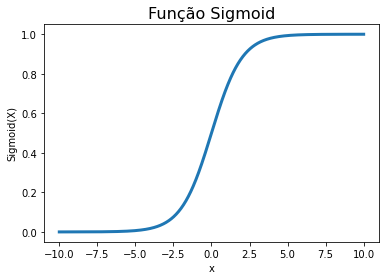

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 1001) 
z = 1/(1 + np.exp(-x)) 
  
plt.plot(x, z, lw=3) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 
  

#decoration
plt.rcParams['figure.figsize'] = 15, 8
plt.title('Função Sigmoid', fontsize=16)
plt.show()

In [ ]:
diff[:10]

# i = 2
# j = 5
# j - i 
# 5 - 2 = 3

# i = 7
# j = 1
# j - i 
# 1 - 7 = -6

array([-10.  ,  -9.98,  -9.96,  -9.94,  -9.92,  -9.9 ,  -9.88,  -9.86,
        -9.84,  -9.82])

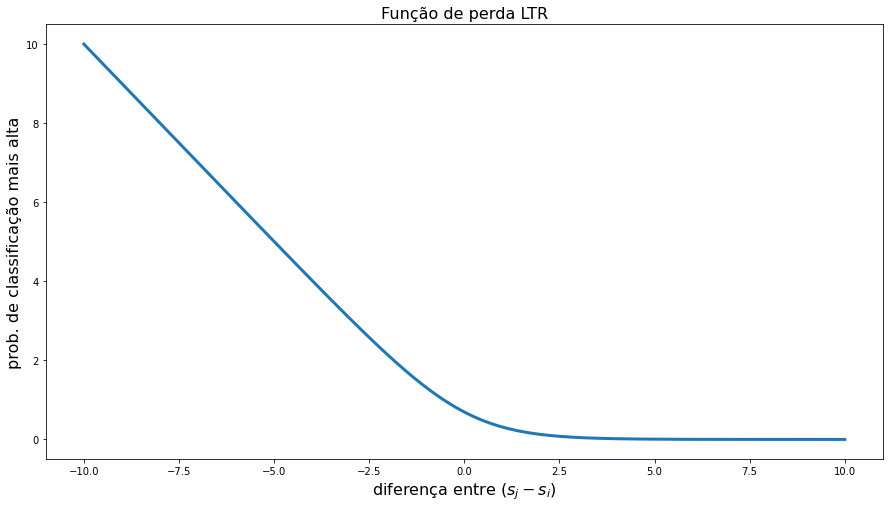

In [ ]:
# Plotando a função de perda da diferença entre sj-si
x = np.linspace(-10, 10, 1001)
diff = np.linspace(10, -10, 1001) #sj-si 

z = np.log(1 + np.exp(diff))

plt.plot(x, z, lw=3)

#decoration
plt.rcParams['figure.figsize'] = 15, 8
plt.title('Função de perda LTR', fontsize=16)
plt.xlabel('diferença entre ($s_j-s_i$)', fontsize=16)
plt.ylabel('prob. de classificação mais alta', fontsize=16)
plt.show()

$s_j-s_i = 10, 9, \dots, 1, 0, -1, \dots, -10$, 

$$
\begin{align}
(s_j-s_i) > 0 &\rightarrow s_j > s_i \\\\  
(s_j-s_i) < 0 &\rightarrow s_i > s_j  
\end{align}
$$ 


#### Como podemos observar, a função de perda é quase linear quando a pontuação do item de classificação mais alta $s_i$ é menor do que a pontuação do item de classificação mais baixa $s_j$, ou seja: $(s_i<s_j)$. E converge para zero quando $(s_i>s_j)$.

#### O conjunto de dados $\mathcal{D}$ será composto de pares de itens $(i, j)$ onde a classificação de $i$ é maior que $j$. Dessa forma, iremos treinar o modelo otimizando $$\sum_{(i,j)\in\mathcal{D}} J_{ij} $$

#### com o gradiente descendente.


# O que o LTR realmente aprende?

#### Para entender como os pesos são atualizados e a classificação, vamos calcular os gradientes da função de perda para um único par $i, j$ em relação a um único parâmetro $\theta_k$.

$$
\begin{align}
\dfrac{\partial J_{ij}}{\partial \theta_k} 
&= \dfrac{\partial J_{ij}}{\partial s_j}\dfrac{\partial s_i}{\partial \theta_k} + \dfrac{\partial J_{ij}}{\partial s_j}\dfrac{\partial s_j}{\partial \theta_k} \\\\
&= \dfrac{-e^{s_j - s_i}}{1+e^{s_j - s_i}} \dfrac{\partial s_i}{\partial \theta_k} + \dfrac{e^{s_j - s_i}}{1+e^{s_j - s_i}}\dfrac{\partial s_j}{\partial \theta_k} \\\\
&= \dfrac{-e^{s_j - s_i}}{1+e^{s_j - s_i}}\left ( \dfrac{\partial s_i}{\partial \theta_k} - \dfrac{\partial s_j}{\partial \theta_k} \right) \\\\
&= \dfrac{-1}{1+e^{s_i - s_j}}\left ( \dfrac{\partial s_i}{\partial \theta_k} - \dfrac{\partial s_j}{\partial \theta_k} \right) \\\\
&:= \lambda_{ij}\left ( \dfrac{\partial s_i}{\partial \theta_k} - \dfrac{\partial s_j}{\partial \theta_k} \right) 
\end{align}
$$

##### onde $\lambda_{ij} = \dfrac{-1}{1+e^{s_i - s_j}}.$


#### Esta equação expõe a essência do *LTR*, então vale a pena entrar em mais detalhes. Como $\lambda_{ij} <0$ dar um passo no gradiente descendente é dar um passo de subida em $s_i$ e um passo de descida em $s_j$ ponderado por $\lambda_ {ij}$. Dessa forma, os pesos são movimentados para aumentar a pontuação do item com a classificação mais alta e diminuir a pontuação do item com a classificação mais baixa, com um certo fator de ponderação.

#### Agora, a questão é: o que exatamente o fator de ponderação $\lambda_{ij}$ significa? Para ter uma ideia melhor, vamos ver como $\lambda_{ij}$ muda de acordo com $s_i - s_j$ (a diferença na pontuação entre os itens de classificação superior e inferior).

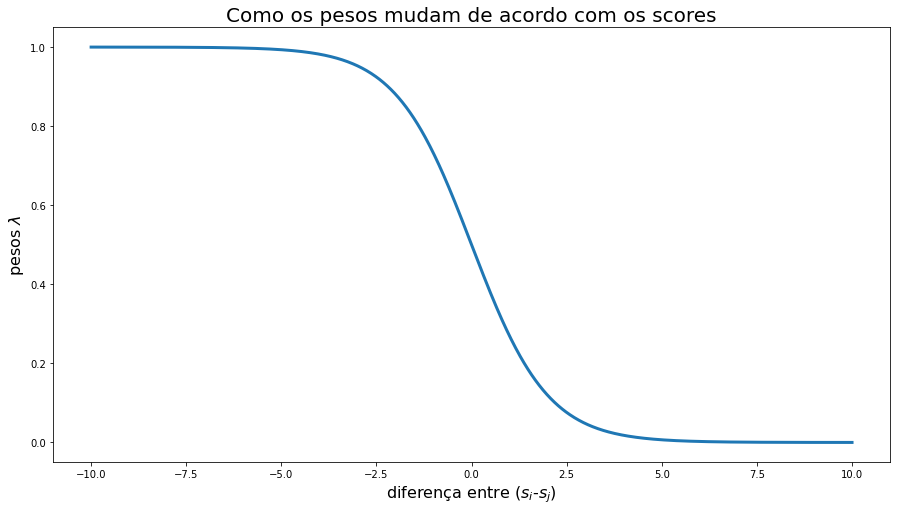

In [ ]:
# Plotando a função de perda da diferença entre sj-si
x = np.linspace(-10, 10, 1001)
diff = np.linspace(-10,10, 1001) #si-sj

z = 1/(1 + np.exp(diff))

plt.plot(x, z, lw=3)

#decoration
plt.rcParams['figure.figsize'] = 15, 8
plt.title('Como os pesos mudam de acordo com os scores', fontsize=20)
plt.xlabel('diferença entre ($s_i$-$s_j$)', fontsize=16)
plt.ylabel('pesos $\lambda$', fontsize=16)
plt.show()

#### Podemos observar que $\lambda_{ij} \rightarrow 0$ quando a diferença $(s_i-s_j)$ fica maior e assintótica em $1$ quando a diferença se aproxima de $-\infty$. Em outras palavras, para pares em que quanto menor a pontuação relativa do item de classificação mais alta $s_i$ em comparação com o item de classificação mais baixa $s_j$, maior será o peso.

In [ ]:
import os
import datetime
import pandas as pd
import numpy as np

from sklearn import preprocessing
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Recommendation-Tutos/MSLR-WEB10K.zip'


Archive:  /content/drive/My Drive/Colab Notebooks/Recommendation-Tutos/MSLR-WEB10K.zip
   creating: Fold1/
  inflating: Fold1/test.txt          
  inflating: Fold1/train.txt         
  inflating: Fold1/vali.txt          
   creating: Fold2/
  inflating: Fold2/test.txt          
  inflating: Fold2/train.txt         
  inflating: Fold2/vali.txt          
   creating: Fold3/
  inflating: Fold3/test.txt          
  inflating: Fold3/train.txt         
  inflating: Fold3/vali.txt          
   creating: Fold4/
  inflating: Fold4/test.txt          
  inflating: Fold4/train.txt         
  inflating: Fold4/vali.txt          
   creating: Fold5/
  inflating: Fold5/test.txt          
  inflating: Fold5/train.txt         
  inflating: Fold5/vali.txt          


In [ ]:
"""
Microsoft Learning to Rank Dataset:
https://www.microsoft.com/en-us/research/project/mslr/
"""


def get_time():
    return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


class DataLoader:

    def __init__(self, path):
        """
        :param path: str
        """
        self.path = path
        self.pickle_path = path[:-3] + 'pkl'
        self.df = None
        self.num_pairs = None
        self.num_sessions = None

    def get_num_pairs(self):
        if self.num_pairs is not None:
            return self.num_pairs
        self.num_pairs = 0
        for _, Y in self.generate_batch_per_query(self.df):
            Y = Y.reshape(-1, 1)
            pairs = Y - Y.T
            pos_pairs = np.sum(pairs > 0, (0, 1))
            neg_pairs = np.sum(pairs < 0, (0, 1))
            assert pos_pairs == neg_pairs
            self.num_pairs += pos_pairs + neg_pairs
        return self.num_pairs

    def get_num_sessions(self):
        return self.num_sessions

    def _load_mslr(self):
        print(get_time(), "load file from {}".format(self.path))
        df = pd.read_csv(self.path, sep=" ", header=None)
        df.drop(columns=df.columns[-1], inplace=True)
        self.num_features = len(df.columns) - 2
        self.num_paris = None
        print(get_time(), "finish loading from {}".format(self.path))
        print("dataframe shape: {}, features: {}".format(df.shape, self.num_features))
        return df

    def _parse_feature_and_label(self, df):
        """
        :param df: pandas.DataFrame
        :return: pandas.DataFrame
        """
        print(get_time(), "parse dataframe ...", df.shape)
        for col in range(1, len(df.columns)):
            if ':' in str(df.iloc[:, col][0]):
                df.iloc[:, col] = df.iloc[:, col].apply(lambda x: x.split(":")[1])
        df.columns = ['rel', 'qid'] + [str(f) for f in range(1, len(df.columns) - 1)]

        for col in [str(f) for f in range(1, len(df.columns) - 1)]:
            df[col] = df[col].astype(np.float32)

        print(get_time(), "finish parsing dataframe")
        self.df = df
        self.num_sessions = len(df.qid.unique())
        return df

    def generate_query_pairs(self, df, qid):
        """
        :param df: pandas.DataFrame, contains column qid, rel, fid from 1 to self.num_features
        :param qid: query id
        :returns: numpy.ndarray of x_i, y_i, x_j, y_j
        """
        df_qid = df[df.qid == qid]
        rels = df_qid.rel.unique()
        x_i, x_j, y_i, y_j = [], [], [], []
        for r in rels:
            df1 = df_qid[df_qid.rel == r]
            df2 = df_qid[df_qid.rel != r]
            df_merged = pd.merge(df1, df2, on='qid')
            df_merged.reindex(np.random.permutation(df_merged.index))
            y_i.append(df_merged.rel_x.values.reshape(-1, 1))
            y_j.append(df_merged.rel_y.values.reshape(-1, 1))
            x_i.append(df_merged[['{}_x'.format(i) for i in range(1, self.num_features + 1)]].values)
            x_j.append(df_merged[['{}_y'.format(i) for i in range(1, self.num_features + 1)]].values)
        return np.vstack(x_i), np.vstack(y_i), np.vstack(x_j), np.vstack(y_j)

    def generate_query_pair_batch(self, df=None, batchsize=2000):
        """
        :param df: pandas.DataFrame, contains column qid
        :returns: numpy.ndarray of x_i, y_i, x_j, y_j
        """
        if df is None:
            df = self.df
        x_i_buf, y_i_buf, x_j_buf, y_j_buf = None, None, None, None
        qids = df.qid.unique()
        np.random.shuffle(qids)
        for qid in qids:
            x_i, y_i, x_j, y_j = self.generate_query_pairs(df, qid)
            if x_i_buf is None:
                x_i_buf, y_i_buf, x_j_buf, y_j_buf = x_i, y_i, x_j, y_j
            else:
                x_i_buf = np.vstack((x_i_buf, x_i))
                y_i_buf = np.vstack((y_i_buf, y_i))
                x_j_buf = np.vstack((x_j_buf, x_j))
                y_j_buf = np.vstack((y_j_buf, y_j))
            idx = 0
            while (idx + 1) * batchsize <= x_i_buf.shape[0]:
                start = idx * batchsize
                end = (idx + 1) * batchsize
                yield x_i_buf[start: end, :], y_i_buf[start: end, :], x_j_buf[start: end, :], y_j_buf[start: end, :]
                idx += 1

            x_i_buf = x_i_buf[idx * batchsize:, :]
            y_i_buf = y_i_buf[idx * batchsize:, :]
            x_j_buf = x_j_buf[idx * batchsize:, :]
            y_j_buf = y_j_buf[idx * batchsize:, :]

        yield x_i_buf, y_i_buf, x_j_buf, y_j_buf

    def generate_query_batch(self, df, batchsize=100000):
        """
        :param df: pandas.DataFrame, contains column qid
        :returns: numpy.ndarray qid, rel, x_i
        """
        idx = 0
        while idx * batchsize < df.shape[0]:
            r = df.iloc[idx * batchsize: (idx + 1) * batchsize, :]
            yield r.qid.values, r.rel.values, r[['{}'.format(i) for i in range(1, self.num_features + 1)]].values
            idx += 1

    def generate_batch_per_query(self, df=None):
        """
        :param df: pandas.DataFrame
        :return: X for features, y for relavance
        :rtype: numpy.ndarray, numpy.ndarray
        """
        if df is None:
            df = self.df
        qids = df.qid.unique()
        np.random.shuffle(qids)
        for qid in qids:
            df_qid = df[df.qid == qid]
            yield df_qid[['{}'.format(i) for i in range(1, self.num_features + 1)]].values, df_qid.rel.values

    def load(self):
        """
        :return: pandas.DataFrame
        """
        if os.path.isfile(self.pickle_path):
            print(get_time(), "load from pickle file {}".format(self.pickle_path))
            self.df = pd.read_pickle(self.pickle_path)
            self.num_features = len(self.df.columns) - 2
            self.num_paris = None
            self.num_sessions = len(self.df.qid.unique())
        else:
            self.df = self._parse_feature_and_label(self._load_mslr())
            self.df.to_pickle(self.pickle_path)
        return self.df

    def train_scaler_and_transform(self):
        """Learn a scalar and apply transform."""
        feature_columns = [str(i) for i in range(1, self.num_features + 1)]
        X_train = self.df[feature_columns]
        scaler = preprocessing.StandardScaler().fit(X_train)
        self.df[feature_columns] = scaler.transform(X_train)
        return self.df, scaler

    def apply_scaler(self, scaler):
        print(get_time(), "apply scaler to transform feature for {}".format(self.path))
        feature_columns = [str(i) for i in range(1, self.num_features + 1)]
        X_train = self.df[feature_columns]
        self.df[feature_columns] = scaler.transform(X_train)
        return self.df

In [ ]:
"""
Metrics:

NDCG:
https://en.wikipedia.org/wiki/Discounted_cumulative_gain
https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf
"""

class DCG(object):

    def __init__(self, k=10, gain_type='exp2'):
        """
        :param k: int DCG@k
        :param gain_type: 'exp2' or 'identity'
        """
        self.k = k
        self.discount = self._make_discount(256)
        if gain_type in ['exp2', 'identity']:
            self.gain_type = gain_type
        else:
            raise ValueError('gain type not equal to exp2 or identity')

    def evaluate(self, targets):
        """
        :param targets: ranked list with relevance
        :return: float
        """
        gain = self._get_gain(targets)
        discount = self._get_discount(min(self.k, len(gain)))
        return np.sum(np.divide(gain, discount))

    def _get_gain(self, targets):
        t = targets[:self.k]
        if self.gain_type == 'exp2':
            return np.power(2.0, t) - 1.0
        else:
            return t

    def _get_discount(self, k):
        if k > len(self.discount):
            self.discount = self._make_discount(2 * len(self.discount))
        return self.discount[:k]

    @staticmethod
    def _make_discount(n):
        x = np.arange(1, n+1, 1)
        discount = np.log2(x + 1)
        return discount


class NDCG(DCG):

    def __init__(self, k=10, gain_type='exp2'):
        """
        :param k: int NDCG@k
        :param gain_type: 'exp2' or 'identity'
        """
        super(NDCG, self).__init__(k, gain_type)

    def evaluate(self, targets):
        """
        :param targets: ranked list with relevance
        :return: float
        """
        dcg = super(NDCG, self).evaluate(targets)
        ideal = np.sort(targets)[::-1]
        idcg = super(NDCG, self).evaluate(ideal)
        return dcg / idcg

    def maxDCG(self, targets):
        """
        :param targets: ranked list with relevance
        :return:
        """
        ideal = np.sort(targets)[::-1]
        return super(NDCG, self).evaluate(ideal)


if __name__ == "__main__":
    targets = [3, 2, 3, 0, 1, 2, 3, 2]
    dcg6 = DCG(6, 'identity')
    ndcg6 = NDCG(6, 'identity')
    assert 6.861 < dcg6.evaluate(targets) < 6.862
    assert 0.785 < ndcg6.evaluate(targets) < 0.786
    ndcg10 = NDCG(10)
    assert 0 < ndcg10.evaluate(targets) < 1.0
    assert 0 < ndcg10.evaluate([1, 2, 3]) < 1.0

In [ ]:
"""
Common function used in training Learn to Rank
"""

# from load_mslr import get_time, DataLoader
# from metrics import NDCG


def get_device():
    if torch.cuda.is_available():
        device = "cuda:{}".format(np.random.randint(torch.cuda.device_count()))
    else:
        device = "cpu"
    print("use device", device)
    return device


def get_ckptdir(net_name, net_structure, sigma=None):
    net_name = '{}-{}'.format(net_name, '-'.join([str(x) for x in net_structure]))
    if sigma:
        net_name += '-scale-{}'.format(sigma)
    ckptdir = '/content/CKPTDIR'
    if not os.path.exists(ckptdir):
        os.makedirs(ckptdir)
    ckptfile = os.path.join(ckptdir, net_name)
    print("checkpoint dir:", ckptfile)
    return ckptfile


def save_to_ckpt(ckpt_file, epoch, model, optimizer, lr_scheduler):
    ckpt_file = ckpt_file + '_{}'.format(epoch)
    print(get_time(), 'save to ckpt {}'.format(ckpt_file))
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
    }, ckpt_file)
    print(get_time(), 'finish save to ckpt {}'.format(ckpt_file))


def load_train_vali_data(data_fold, small_dataset=False):
    """
    :param data_fold: str, which fold's data was going to use to train
    :return:
    """
    if small_dataset:
        train_file, valid_file = "vali.txt", "test.txt"
    else:
        train_file, valid_file = "train.txt", "vali.txt"

    data_dir = '/content/'
    train_data = os.path.join(data_dir, data_fold, train_file)
    train_loader = DataLoader(train_data)
    df_train = train_loader.load()

    valid_data = os.path.join(data_dir, data_fold, valid_file)
    valid_loader = DataLoader(valid_data)
    df_valid = valid_loader.load()
    return train_loader, df_train, valid_loader, df_valid


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def eval_cross_entropy_loss(model, device, loader, epoch, writer=None, phase="Eval", sigma=1.0):
    """
    formula in https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf

    C = 0.5 * (1 - S_ij) * sigma * (si - sj) + log(1 + exp(-sigma * (si - sj)))
    when S_ij = 1:  C = log(1 + exp(-sigma(si - sj)))
    when S_ij = -1: C = log(1 + exp(-sigma(sj - si)))
    sigma can change the shape of the curve
    """
    print(get_time(), "{} Phase evaluate pairwise cross entropy loss".format(phase))
    model.eval()
    with torch.set_grad_enabled(False):
        total_cost = 0
        total_pairs = loader.get_num_pairs()
        pairs_in_compute = 0
        for X, Y in loader.generate_batch_per_query(loader.df):
            Y = Y.reshape(-1, 1)
            rel_diff = Y - Y.T
            pos_pairs = (rel_diff > 0).astype(np.float32)
            num_pos_pairs = np.sum(pos_pairs, (0, 1))
            # skip negative sessions, no relevant info:
            if num_pos_pairs == 0:
                continue
            neg_pairs = (rel_diff < 0).astype(np.float32)
            num_pairs = 2 * num_pos_pairs  # num pos pairs and neg pairs are always the same
            pos_pairs = torch.tensor(pos_pairs, device=device)
            neg_pairs = torch.tensor(neg_pairs, device=device)
            Sij = pos_pairs - neg_pairs
            # only calculate the different pairs
            diff_pairs = pos_pairs + neg_pairs
            pairs_in_compute += num_pairs

            X_tensor = torch.Tensor(X).to(device)
            y_pred = model(X_tensor)
            y_pred_diff = y_pred - y_pred.t()

            # logsigmoid(x) = log(1 / (1 + exp(-x))) equivalent to log(1 + exp(-x))
            C = 0.5 * (1 - Sij) * sigma * y_pred_diff - F.logsigmoid(-sigma * y_pred_diff)
            C = C * diff_pairs
            cost = torch.sum(C, (0, 1))
            if cost.item() == float('inf') or np.isnan(cost.item()):
                import ipdb; ipdb.set_trace()
            total_cost += cost

        assert total_pairs == pairs_in_compute
        avg_cost = total_cost / total_pairs
    print(
        get_time(),
        f"Epoch {epoch}: {phase} Phase pairwise cross entropy loss {avg_cost.item():.6f}, total_paris {total_pairs}"
        ))
    if writer:
        writer.add_scalars('loss/cross_entropy', {phase: avg_cost.item()}, epoch)


def eval_ndcg_at_k(
        inference_model, device, df_valid, valid_loader, batch_size, k_list, epoch,
        writer=None, phase="Eval"
):
    # print("Eval Phase evaluate NDCG @ {}".format(k_list))
    ndcg_metrics = {k: NDCG(k) for k in k_list}
    qids, rels, scores = [], [], []
    inference_model.eval()
    with torch.no_grad():
        for qid, rel, x in valid_loader.generate_query_batch(df_valid, batch_size):
            if x is None or x.shape[0] == 0:
                continue
            y_tensor = inference_model.forward(torch.Tensor(x).to(device))
            scores.append(y_tensor.cpu().numpy().squeeze())
            qids.append(qid)
            rels.append(rel)

    qids = np.hstack(qids)
    rels = np.hstack(rels)
    scores = np.hstack(scores)
    result_df = pd.DataFrame({'qid': qids, 'rel': rels, 'score': scores})
    session_ndcgs = defaultdict(list)
    for qid in result_df.qid.unique():
        result_qid = result_df[result_df.qid == qid].sort_values('score', ascending=False)
        rel_rank = result_qid.rel.values
        for k, ndcg in ndcg_metrics.items():
            if ndcg.maxDCG(rel_rank) == 0:
                continue
            ndcg_k = ndcg.evaluate(rel_rank)
            if not np.isnan(ndcg_k):
                session_ndcgs[k].append(ndcg_k)

    ndcg_result = {k: np.mean(session_ndcgs[k]) for k in k_list}
    ndcg_result_print = ", ".join(["NDCG@{}: {:.5f}".format(k, ndcg_result[k]) for k in k_list])
    print(get_time(), "{} Phase evaluate {}".format(phase, ndcg_result_print))
    if writer:
        for k in k_list:
            writer.add_scalars("metrics/NDCG@{}".format(k), {phase: ndcg_result[k]}, epoch)
    return ndcg_result


def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise ArgumentTypeError('Boolean value expected.')


def get_args_parser():
    """Common Args needed for different Learn to Rank training method.
    :rtype: ArgumentParser
    """
    parser = ArgumentParser(description="additional training specification")
    parser.add_argument("--start_epoch", dest="start_epoch", type=int, default=0)
    parser.add_argument("--additional_epoch", dest="additional_epoch", type=int, default=100)
    parser.add_argument("--lr", dest="lr", type=float, default=0.0001)
    parser.add_argument("--optim", dest="optim", type=str, default="adam", choices=["adam", "sgd"])
    parser.add_argument("--leaky_relu", dest="leaky_relu", type=str2bool, nargs="?", const=True, default=False)
    parser.add_argument(
        "--ndcg_gain_in_train", dest="ndcg_gain_in_train",
        type=str, default="exp2", choices=["exp2","identity"]
    )
    parser.add_argument("--small_dataset", type=str2bool, nargs='?', const=True, default=False)
    parser.add_argument("--debug", type=str2bool, nargs='?', const=True, default=False)
    parser.add_argument("--double_precision", type=str2bool, nargs="?", const=True, default=False)
    parser.add_argument("--standardize", type=str2bool, nargs="?", const=True, default=False)
    parser.add_argument("--output_dir", dest="output_dir", type=str, default="/tmp/ranking_output/")
    return parser

In [ ]:
"""
LambdaRank:
From RankNet to LambdaRank to LambdaMART: An Overview
https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf
https://papers.nips.cc/paper/2971-learning-to-rank-with-nonsmooth-cost-functions.pdf

ListWise Rank
1. For each query's returned document, calculate the score Si, and rank i (forward pass)
    dS / dw is calculated in this step
2. Without explicit define the loss function L, dL / dw_k = Sum_i [(dL / dS_i) * (dS_i / dw_k)]
3. for each document Di, find all other pairs j, calculate lambda:
    for rel(i) > rel(j)
    lambda += - N / (1 + exp(Si - Sj)) * (gain(rel_i) - gain(rel_j)) * |1/log(pos_i+1) - 1/log(pos_j+1)|
    for rel(i) < rel(j)
    lambda += - N / (1 + exp(Sj - Si)) * (gain(rel_i) - gain(rel_j)) * |1/log(pos_i+1) - 1/log(pos_j+1)|
    and lambda is dL / dS_i
4. in the back propagate send lambda backward to update w

to compare with RankNet factorization, the gradient back propagate is:
    pos pairs
    lambda += - 1/(1 + exp(Si - Sj))
    neg pairs
    lambda += 1/(1 + exp(Sj - Si))

to reduce the computation:
    in RankNet
    lambda = sigma * (0.5 * (1 - Sij) - 1 / (1 + exp(sigma *(Si - Sj)))))
    when Rel_i > Rel_j, Sij = 1:
        lambda = -sigma / (1 + exp(sigma(Si - Sj)))
    when Rel_i < Rel_j, Sij = -1:
        lambda = sigma  / (1 + exp(sigma(Sj - Si)))

    in LambdaRank
    lambda = sigma * (0.5 * (1 - Sij) - 1 / (1 + exp(sigma *(Si - Sj))))) * |delta_NDCG|
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

# from load_mslr import get_time
# from metrics import NDCG
# from utils import (
#     eval_cross_entropy_loss,
#     eval_ndcg_at_k,
#     get_device,
#     get_ckptdir,
#     init_weights,
#     load_train_vali_data,
#     get_args_parser,
#     save_to_ckpt,
# )


class LambdaRank(nn.Module):
    def __init__(self, net_structures, leaky_relu=False, sigma=1.0, double_precision=False):
        """Fully Connected Layers with Sigmoid activation at the last layer

        :param net_structures: list of int for LambdaRank FC width
        """
        super(LambdaRank, self).__init__()
        self.fc_layers = len(net_structures)
        for i in range(len(net_structures) - 1):
            setattr(self, 'fc' + str(i + 1), nn.Linear(net_structures[i], net_structures[i+1]))
            if leaky_relu:
                setattr(self, 'act' + str(i + 1), nn.LeakyReLU())
            else:
                setattr(self, 'act' + str(i + 1), nn.ReLU())
        setattr(self, 'fc' + str(len(net_structures)), nn.Linear(net_structures[-1], 1))
        if double_precision:
            for i in range(1, len(net_structures) + 1):
                setattr(self, 'fc' + str(i), getattr(self, 'fc' + str(i)).double())
        self.sigma = sigma
        # self.activation = nn.Sigmoid()
        self.activation = nn.ReLU6()

    def forward(self, input1):
        # from 1 to N - 1 layer, use ReLU as activation function
        for i in range(1, self.fc_layers):
            fc = getattr(self, 'fc' + str(i))
            act = getattr(self, 'act' + str(i))
            input1 = act(fc(input1))

        fc = getattr(self, 'fc' + str(self.fc_layers))
        return self.activation(fc(input1)) * self.sigma

    def dump_param(self):
        for i in range(1, self.fc_layers + 1):
            print("fc{} layers".format(i))
            fc = getattr(self, 'fc' + str(i))

            with torch.no_grad():
                weight_norm, weight_grad_norm = torch.norm(fc.weight).item(), torch.norm(fc.weight.grad).item()
                bias_norm, bias_grad_norm = torch.norm(fc.bias).item(), torch.norm(fc.bias.grad).item()
            try:
                weight_ratio = weight_grad_norm / weight_norm if weight_norm else float('inf') if weight_grad_norm else 0.0
                bias_ratio = bias_grad_norm / bias_norm if bias_norm else float('inf') if bias_grad_norm else 0.0
            except Exception:
                import ipdb; ipdb.set_trace()

            print(
                '\tweight norm {:.4e}'.format(weight_norm), ', grad norm {:.4e}'.format(weight_grad_norm),
                ', ratio {:.4e}'.format(weight_ratio),
                # 'weight type {}, weight grad type {}'.format(fc.weight.type(), fc.weight.grad.type())
            )
            print(
                '\tbias norm {:.4e}'.format(bias_norm), ', grad norm {:.4e}'.format(bias_grad_norm),
                ', ratio {:.4e}'.format(bias_ratio),
                # 'bias type {}, bias grad type {}'.format(fc.bias.type(), fc.bias.grad.type())
            )


#####################
# test LambdaRank
######################
def train(
    start_epoch=0, additional_epoch=100, lr=0.0001, optim="adam", leaky_relu=False,
    ndcg_gain_in_train="exp2", sigma=1.0,
    double_precision=False, standardize=False,
    small_dataset=False, debug=False,
    output_dir="/content/",
):
    print("start_epoch:{}, additional_epoch:{}, lr:{}".format(start_epoch, additional_epoch, lr))
    writer = SummaryWriter(output_dir)

    precision = torch.float64 if double_precision else torch.float32

    # get training and validation data:
    data_fold = 'Fold1'
    train_loader, df_train, valid_loader, df_valid = load_train_vali_data(data_fold, small_dataset)
    if standardize:
        df_train, scaler = train_loader.train_scaler_and_transform()
        df_valid = valid_loader.apply_scaler(scaler)

    lambdarank_structure = [136, 64, 16]

    net = LambdaRank(lambdarank_structure, leaky_relu=leaky_relu, double_precision=double_precision, sigma=sigma)
    device = get_device()
    net.to(device)
    net.apply(init_weights)
    print(net)

    ckptfile = get_ckptdir('lambdarank', lambdarank_structure, sigma)

    if optim == "adam":
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    elif optim == "sgd":
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError("Optimization method {} not implemented".format(optim))
    print(optimizer)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

    ideal_dcg = NDCG(2**9, ndcg_gain_in_train)

    for i in range(start_epoch, start_epoch + additional_epoch):
        net.train()
        net.zero_grad()

        count = 0
        batch_size = 200
        grad_batch, y_pred_batch = [], []

        for X, Y in train_loader.generate_batch_per_query():
            if np.sum(Y) == 0:
                # negative session, cannot learn useful signal
                continue
            N = 1.0 / ideal_dcg.maxDCG(Y)

            X_tensor = torch.tensor(X, dtype=precision, device=device)
            y_pred = net(X_tensor)
            y_pred_batch.append(y_pred)
            # compute the rank order of each document
            rank_df = pd.DataFrame({"Y": Y, "doc": np.arange(Y.shape[0])})
            rank_df = rank_df.sort_values("Y").reset_index(drop=True)
            rank_order = rank_df.sort_values("doc").index.values + 1

            with torch.no_grad():
                pos_pairs_score_diff = 1.0 + torch.exp(sigma * (y_pred - y_pred.t()))

                Y_tensor = torch.tensor(Y, dtype=precision, device=device).view(-1, 1)
                rel_diff = Y_tensor - Y_tensor.t()
                pos_pairs = (rel_diff > 0).type(precision)
                neg_pairs = (rel_diff < 0).type(precision)
                Sij = pos_pairs - neg_pairs
                if ndcg_gain_in_train == "exp2":
                    gain_diff = torch.pow(2.0, Y_tensor) - torch.pow(2.0, Y_tensor.t())
                elif ndcg_gain_in_train == "identity":
                    gain_diff = Y_tensor - Y_tensor.t()
                else:
                    raise ValueError("ndcg_gain method not supported yet {}".format(ndcg_gain_in_train))

                rank_order_tensor = torch.tensor(rank_order, dtype=precision, device=device).view(-1, 1)
                decay_diff = 1.0 / torch.log2(rank_order_tensor + 1.0) - 1.0 / torch.log2(rank_order_tensor.t() + 1.0)

                delta_ndcg = torch.abs(N * gain_diff * decay_diff)
                lambda_update = sigma * (0.5 * (1 - Sij) - 1 / pos_pairs_score_diff) * delta_ndcg
                lambda_update = torch.sum(lambda_update, 1, keepdim=True)

                assert lambda_update.shape == y_pred.shape
                check_grad = torch.sum(lambda_update, (0, 1)).item()
                if check_grad == float('inf') or np.isnan(check_grad):
                    import ipdb; ipdb.set_trace()
                grad_batch.append(lambda_update)

            # optimization is to similar to RankNetListWise, but to maximize NDCG.
            # lambda_update scales with gain and decay

            count += 1
            if count % batch_size == 0:
                for grad, y_pred in zip(grad_batch, y_pred_batch):
                    y_pred.backward(grad / batch_size)

                if count % (4 * batch_size) == 0 and debug:
                    net.dump_param()

                optimizer.step()
                net.zero_grad()
                grad_batch, y_pred_batch = [], []  # grad_batch, y_pred_batch used for gradient_acc

        # optimizer.step()
        print(get_time(), "training dataset at epoch {}, total queries: {}".format(i, count))
        if debug:
            eval_cross_entropy_loss(net, device, train_loader, i, writer, phase="Train")
        # eval_ndcg_at_k(net, device, df_train, train_loader, 100000, [10, 30, 50])

        if i % 5 == 0 and i != start_epoch:
            print(get_time(), "eval for epoch: {}".format(i))
            eval_cross_entropy_loss(net, device, valid_loader, i, writer)
            eval_ndcg_at_k(net, device, df_valid, valid_loader, 100000, [10, 30], i, writer)
        if i % 10 == 0 and i != start_epoch:
            save_to_ckpt(ckptfile, i, net, optimizer, scheduler)

        scheduler.step()

    # save the last ckpt
    save_to_ckpt(ckptfile, start_epoch + additional_epoch, net, optimizer, scheduler)

    # save the final model
    torch.save(net.state_dict(), ckptfile)
    ndcg_result = eval_ndcg_at_k(
        net, device, df_valid, valid_loader, 100000, [10, 30], start_epoch + additional_epoch,
        writer)
    print(
        get_time(),
        "finish training " + ", ".join(
            ["NDCG@{}: {:.5f}".format(k, ndcg_result[k]) for k in ndcg_result]
        ),
        '\n\n'
    )


if __name__ == "__main__":
    # parser = get_args_parser()
    # parser.add_argument("--sigma", dest="sigma", type=float, default=1.0)
    # args = parser.parse_args()
    train()


start_epoch:0, additional_epoch:100, lr:0.0001
2020-08-26 04:30:13 load file from /content/Fold1/train.txt
2020-08-26 04:30:55 finish loading from /content/Fold1/train.txt
dataframe shape: (723412, 138), features: 136
2020-08-26 04:30:55 parse dataframe ... (723412, 138)
2020-08-26 04:33:31 finish parsing dataframe
2020-08-26 04:33:34 load file from /content/Fold1/vali.txt
2020-08-26 04:33:47 finish loading from /content/Fold1/vali.txt
dataframe shape: (235259, 138), features: 136
2020-08-26 04:33:47 parse dataframe ... (235259, 138)
2020-08-26 04:34:37 finish parsing dataframe
use device cuda:0
LambdaRank(
  (fc1): Linear(in_features=136, out_features=64, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU6()
)
checkpoint dir: /content/CKPTDIR/lambdarank-136-64-16-scale-1.0
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-0

KeyboardInterrupt: ignored